<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/inception_v1(TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

# 패키지 불러오기

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 3.4 MB/s 
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , ReLU, MaxPooling2D , GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D, Add, AveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A

# 논문분석

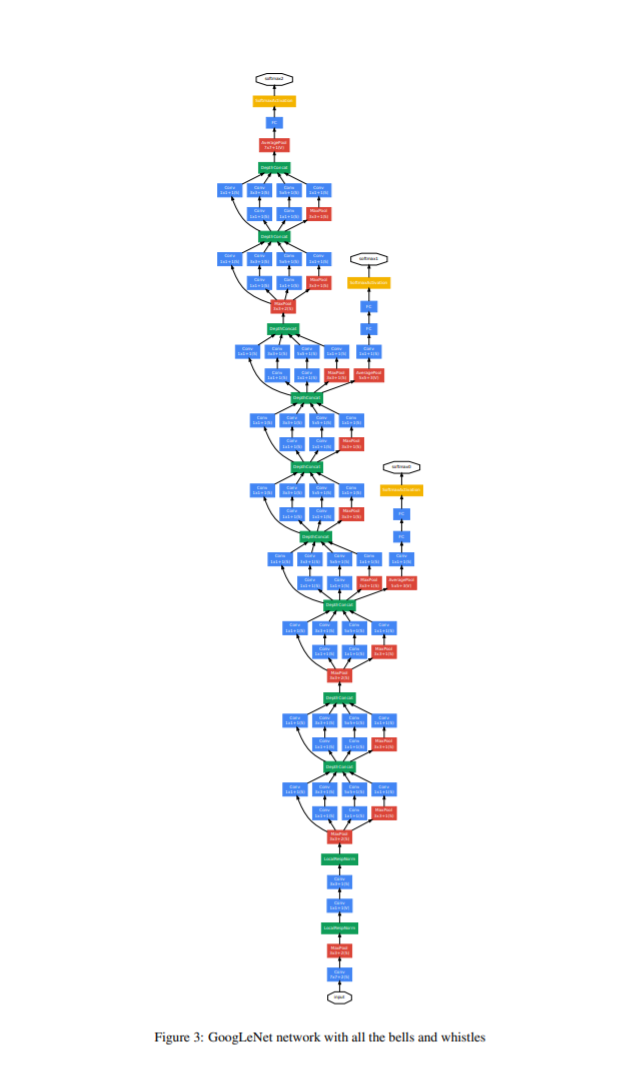

* Inception v1의 주요 특징은 위와 같은 인셉션 모듈이다. 이는, sparse한 구조와 dense한 연산과정을 적절하게 조합해낸 것.
* 좀 더 깊게 들어가보면, 실제 생물은 꽉 차있는 dense한 뉴런이 아니라 sparse하게 뉴런이 구조되어있으면, 어떠한 자극에 대해서 모든 뉴런이 반응하는 것이 아니라, 관련성이 높은 뉴런들끼리 Fire된다. 
* 그렇지만 sparse하게만 코드를 구성한다면, GPU연산의 장점인 dense한 병렬계산을 제대로 이용 할 수 없다. 파라미터 양은 실제로 줄어들지 몰라도 연산과정에서 시간이 오히려 더 들어간다.
* 이런 점들을 모방하기 위해 생각해 낸 아이디어가 위의 인셉션

* 여기서 1x1conv가 나오는데 이는 계산량, 채널수 조절 뿐만 아니라, relu를 거치게하여 비선형성을 추가하는데도 사용할 수 있음. + 비슷한 성질을 갖는 것끼리 묶어내는 역할
* Auxiliary classifier도 있는데 이는 나중 버전에서는 사라짐. 이것 또한 구현해보자.
* 모델 구현이 핵심이기에 이미지 사이즈, 데이터 증강, 가중치 초기화 등은 임의로 결정



# 모델 구현

## 인셉션 모듈 구현

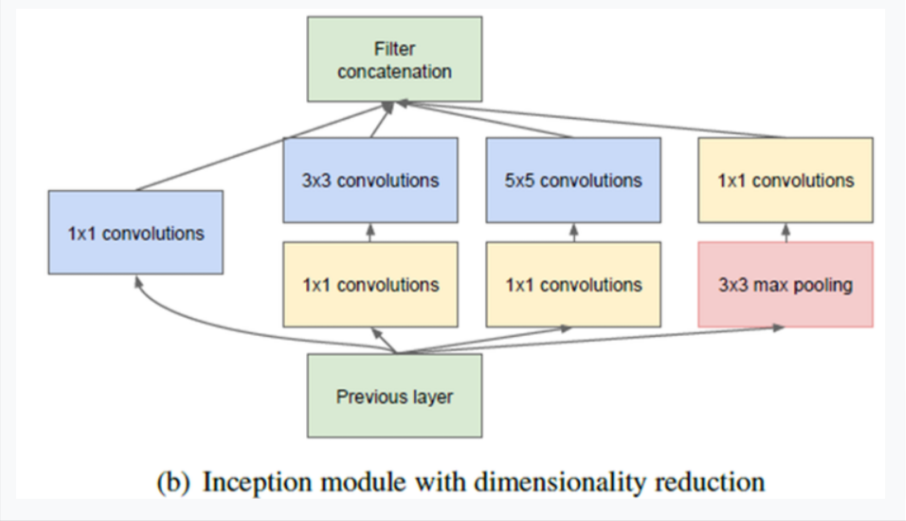

In [ ]:
def inception_module(x, filters_1x1, filters_3x3_r, filters_3x3, filters_5x5_r, filters_5x5, filters_pool) :
    # 1x1
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3
    conv_3x3 = Conv2D(filters_3x3_r, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    #5x5
    conv_5x5 = Conv2D(filters_5x5_r, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # maxpooling
    pool_3x3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_3x3 = Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(pool_3x3)

    output = tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_3x3])
    return output

## auxiliary 구현
* vanishing gradient를 막아준다.(Rugularization효과)
* 오버피팅을 막아준다.

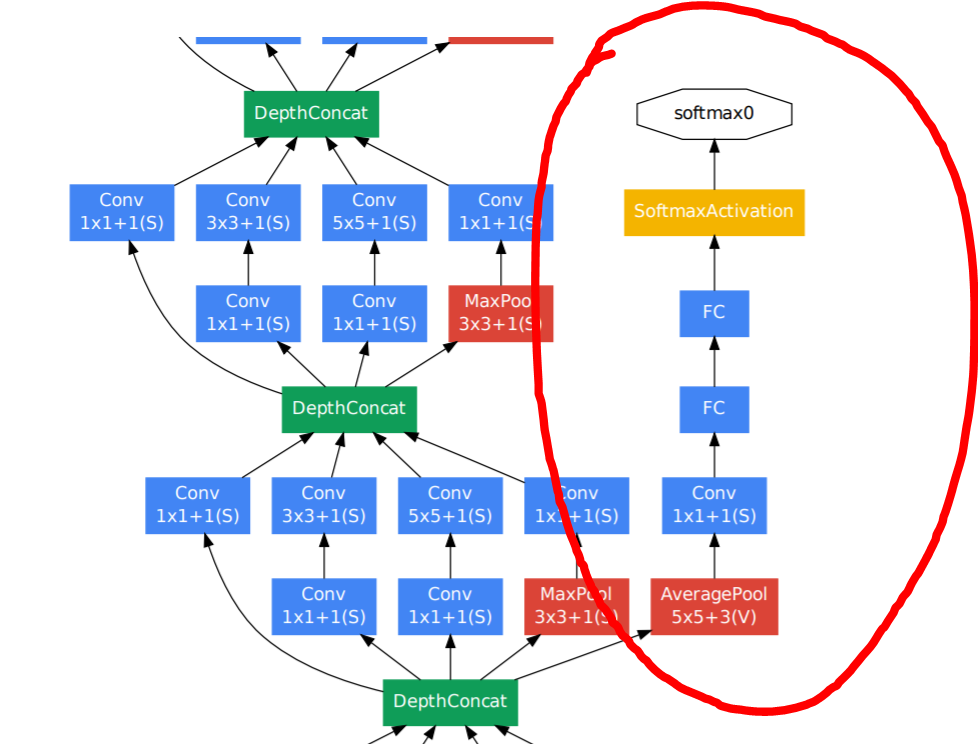

In [ ]:
def auxiliary_module(x):
    auxiliary = AveragePooling2D((5, 5), strides=3, padding='valid')(x)
    auxiliary = Conv2D(128, (1, 1), strides=1, padding='same', activation='relu')(auxiliary)
    auxiliary = Flatten()(auxiliary)
    auxiliary = Dense(1024, activation='relu')(auxiliary)
    auxiliary = Dropout(0.7)(auxiliary)
    auxiliary= Dense(10, activation='softmax')(auxiliary)
    
    return auxiliary

## inception v1 구현

In [ ]:
def create_inception_v1() :
    input_tensor = Input((224,224,3))

    x = Conv2D(64, (7, 7),  strides=(2, 2), padding='same',activation='relu')(input_tensor)
    x = MaxPooling2D((3, 3),  strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1),  strides=(1, 1), padding='same',activation='relu')(x)
    x = Conv2D(192, (3, 3),  strides=(1, 1), padding='same',activation='relu')(x)
    x = MaxPooling2D((3, 3),  strides=(2, 2), padding='same')(x)
    
    # inception module 3a, 3b
    x = inception_module(x, 64,96,128,16,32,32)
    x = inception_module(x, 128,128,192,32,96,64)
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

    # inception module 4a, axuiliary_a 4b, 4c, 4d, axuiliary_b, 4e
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    ax_a = auxiliary_module(x)

    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    ax_b = auxiliary_module(x)

    x = inception_module(x,256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

    # inception module 5a, 5b
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    # top layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)    
    x = Dense(10, activation='relu')(x)
    model_output = Dense(10, activation='softmax')(x)

    model = Model(input_tensor, [model_output, ax_a, ax_b])
    return model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

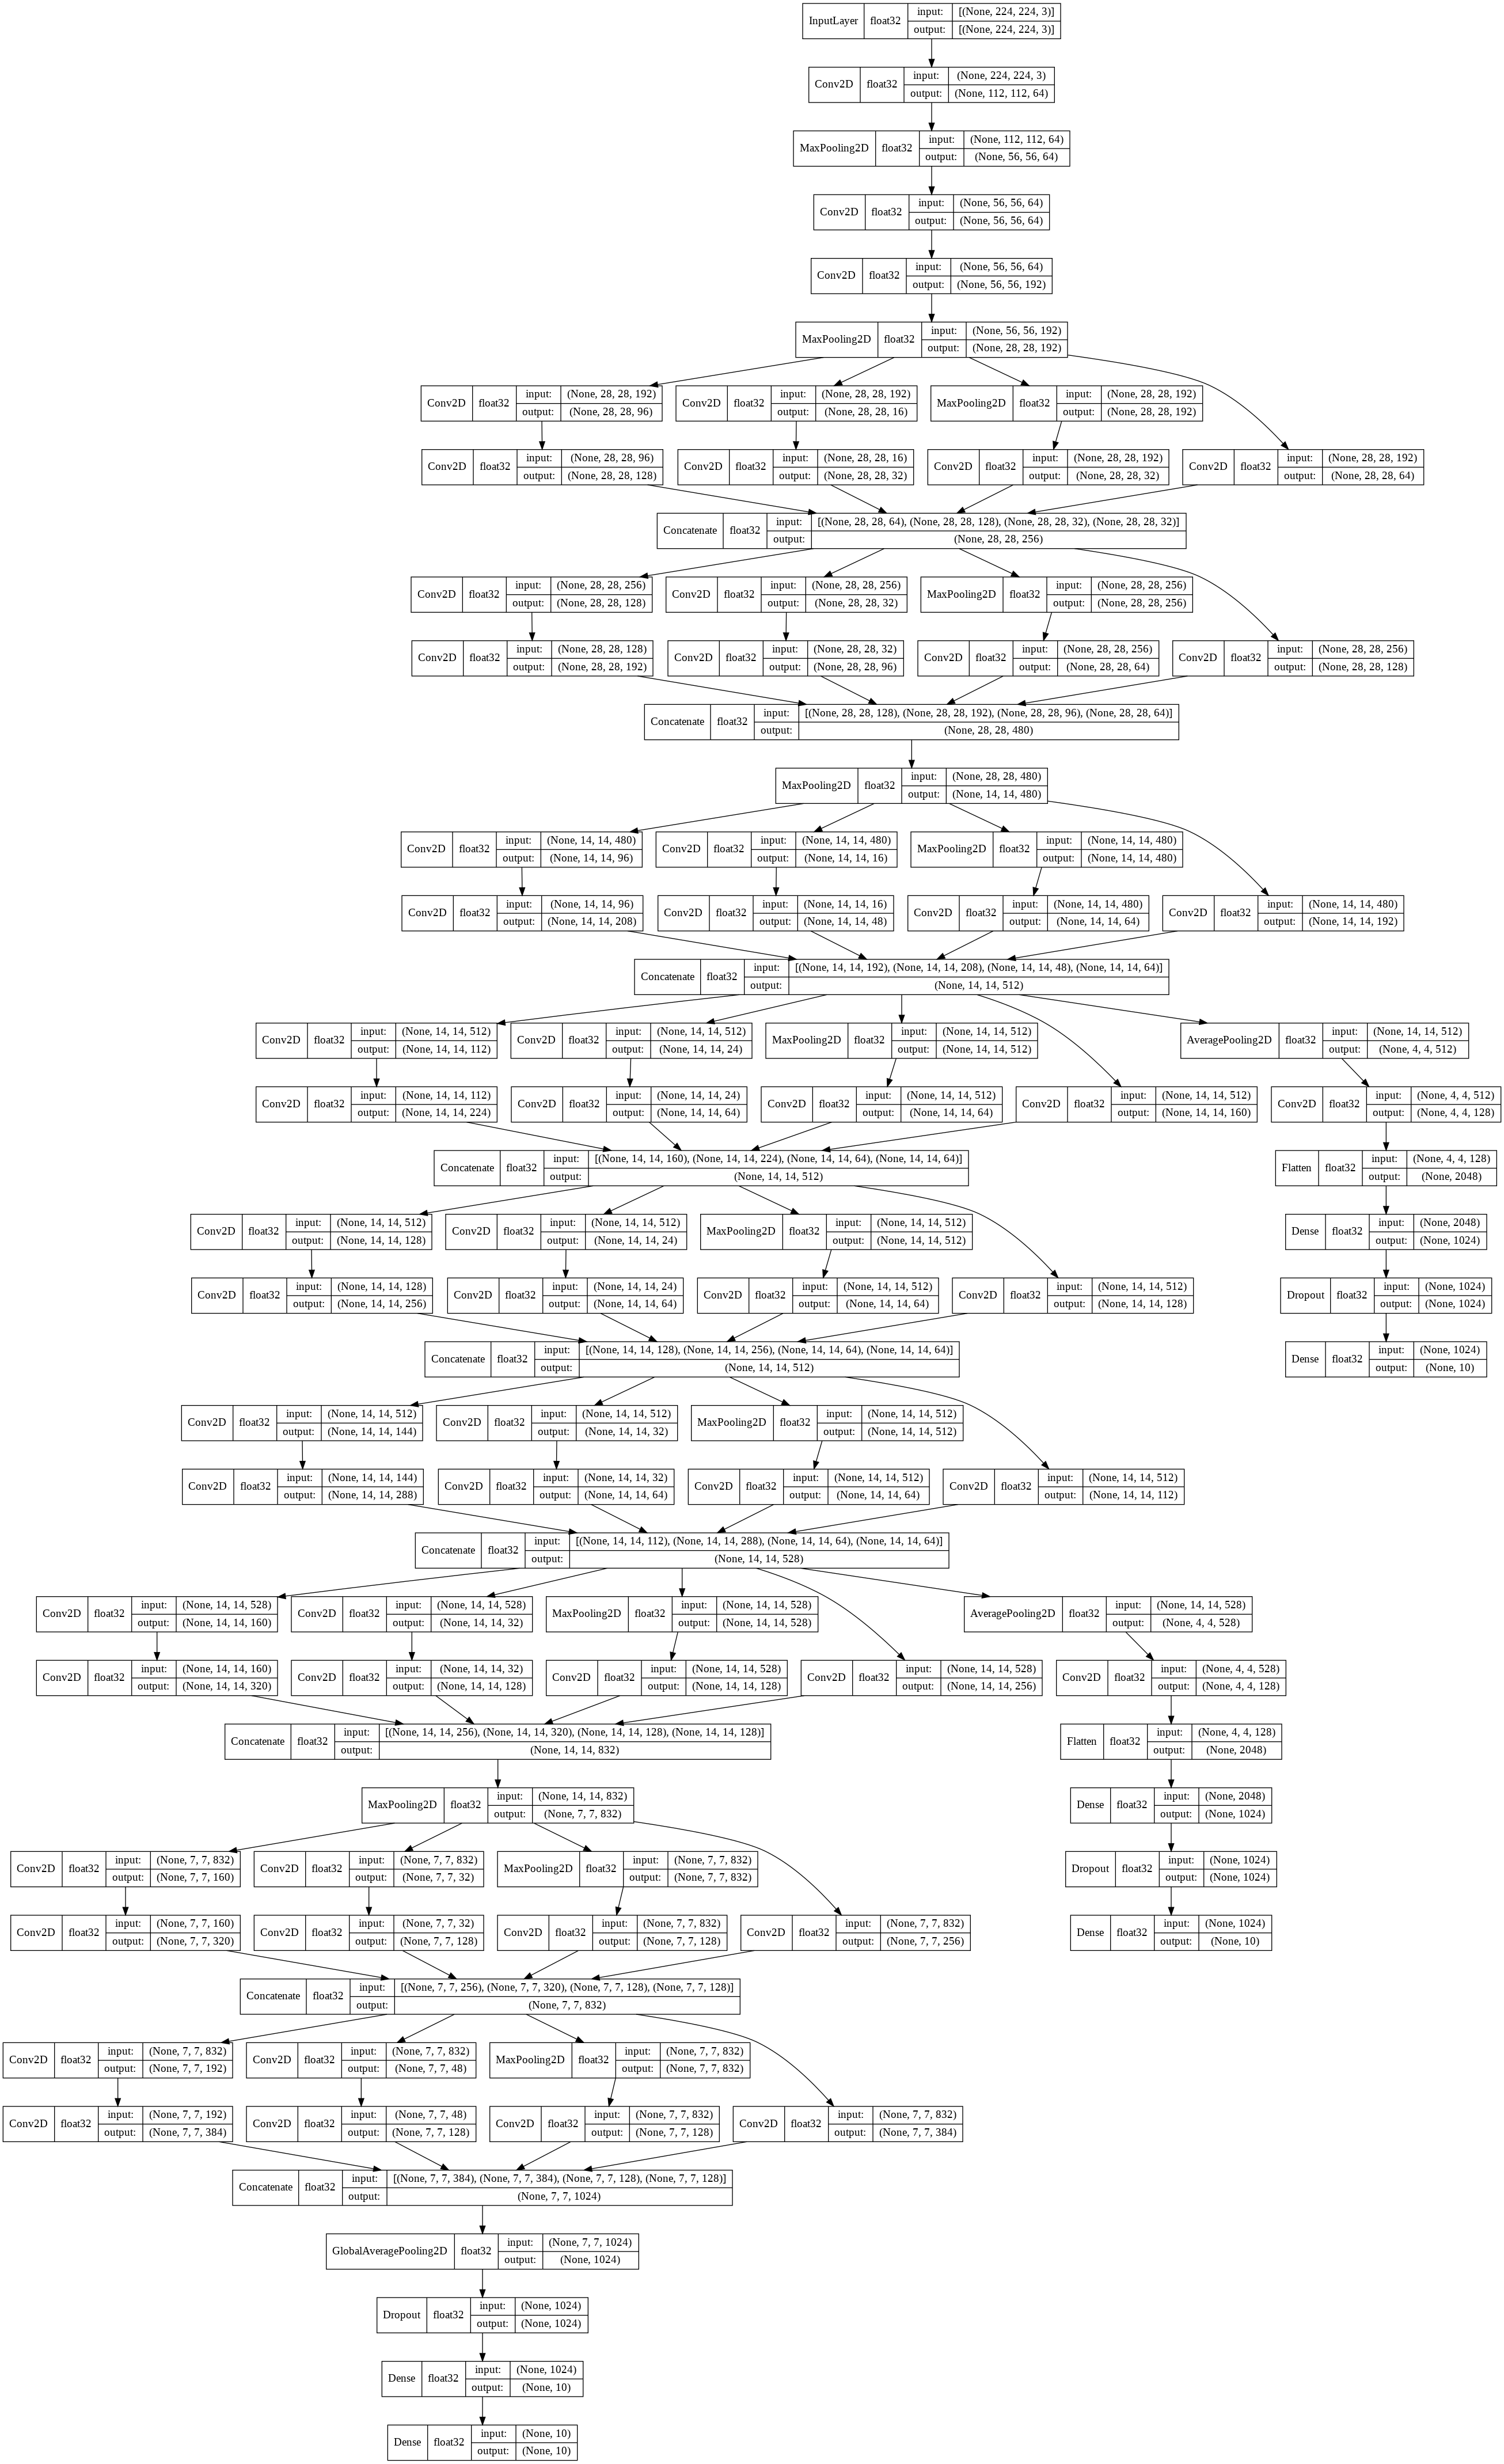

In [ ]:
model = create_inception_v1()
model.summary()
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, show_dtype=True)

# CIFAR10 전처리

## 데이터 로드 및 분할


In [ ]:
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

In [ ]:
(tr_im, tr_lb), (test_images, t_lb) = cifar10.load_data()

# 웟핫 인코딩
tr_oh_lb = to_categorical(tr_lb)
test_labels = to_categorical(t_lb)

# 훈련 세트 분할
train_images,  val_images , train_labels, val_labels = train_test_split(tr_im,tr_oh_lb, test_size=0.2 ,random_state = 403)


print(train_images.shape, train_labels.shape,val_images.shape, val_labels.shape,test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 4s 0us/step
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


## Sequence Dateset 생성

ram 부족해결 + albu 사용을 위해(배치단위 입력)

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import preprocess_input as dense_pr_input
class DataSet(Sequence): 
    def __init__(self, images_array, labels, batch_size, image_size=(256,256), augmentor=None, shuffle=False, pre_func =None):
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentor= augmentor
        self.pre_func = pre_func
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            self.on_epoch_end()
            pass

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        pre_im_batch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        image_batch = np.zeros((pre_im_batch.shape[0],self.image_size[0],self.image_size[1], 3), dtype='float32')

        for i in range(pre_im_batch.shape[0]):
            image = cv2.resize(pre_im_batch[i], self.image_size )

            if self.augmentor is not None:
                image = self.augmentor(image=image)['image'] 

            if self.pre_func is not None:
                for func in self.pre_func:
                    image = func(image)

            image = cv2.resize(image, self.image_size )

            image_batch[i] = image
                
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)



## 증강
증강은 성능 및 속도를 위해서 임의로 추가.

In [ ]:
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2)

])

# fit 및 평가

In [ ]:
model.compile(optimizer=SGD(lr=0.01, momentum= 0.09,decay =0.0005 ), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_dataset = DataSet(train_images, train_labels, batch_size=64, augmentor=augmentor, shuffle=True, pre_func = [dense_pr_input])
val_dataset = DataSet(val_images, val_labels, batch_size=64, augmentor=None, shuffle=False, pre_func = [dense_pr_input])

In [ ]:
# 3번 validation error 가 개선되지 않으면 lr에 0.1곱함
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='min', verbose=1)
# 3번 동안 개선이 없다면 조기종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [ ]:
history = model.fit(train_dataset, epochs=30, 
                    validation_data=val_dataset ,
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/30
625/625 [==============================] - 208s 296ms/step - loss: 6.7048 - dense_5_loss: 2.2689 - dense_1_loss: 2.2045 - dense_3_loss: 2.2314 - dense_5_accuracy: 0.1251 - dense_1_accuracy: 0.1725 - dense_3_accuracy: 0.1555 - val_loss: 6.2908 - val_dense_5_loss: 2.1976 - val_dense_1_loss: 2.0267 - val_dense_3_loss: 2.0666 - val_dense_5_accuracy: 0.1842 - val_dense_1_accuracy: 0.2551 - val_dense_3_accuracy: 0.2183
Epoch 2/30
625/625 [==============================] - 188s 300ms/step - loss: 6.1488 - dense_5_loss: 2.1448 - dense_1_loss: 1.9755 - dense_3_loss: 2.0285 - dense_5_accuracy: 0.1955 - dense_1_accuracy: 0.2653 - dense_3_accuracy: 0.2350 - val_loss: 5.7533 - val_dense_5_loss: 2.0570 - val_dense_1_loss: 1.8192 - val_dense_3_loss: 1.8771 - val_dense_5_accuracy: 0.2130 - val_dense_1_accuracy: 0.3444 - val_dense_3_accuracy: 0.3103
Epoch 3/30
625/625 [==============================] - 190s 304ms/step - loss: 5.7386 - dense_5_loss: 2.0264 - dense_1_loss: 1.8250 - dense_3_los

In [ ]:
# 평가
test_dataset = DataSet(test_images, test_labels, batch_size=64, pre_func = [dense_pr_input])
print(model.evaluate(test_dataset))



157/157 [==============================] - 18s 116ms/step - loss: 3.3542 - dense_5_loss: 1.2131 - dense_1_loss: 1.0561 - dense_3_loss: 1.0849 - dense_5_accuracy: 0.5742 - dense_1_accuracy: 0.6261 - dense_3_accuracy: 0.6189
[3.3541526794433594, 1.2130844593048096, 1.0561374425888062, 1.084930419921875, 0.5741999745368958, 0.6261000037193298, 0.6189000010490417]
